# Implementing the U-Net Architecture
The paper uses a U-Net architecture for doing the image inpainting. We've implemented this in `libs/unet.py` module, and we will review it here.

In [1]:
import gc
from copy import deepcopy
import cv2
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

import matplotlib
import matplotlib.pyplot as plt

from libs.util import random_mask, single_rect_mask
from libs.pconv_model import PConvUnet

# Settings
MAX_BATCH_SIZE = 128

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
PConvUnet().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_img (InputLayer)         (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
inputs_mask (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
p_conv2d_1 (PConv2D)            [(None, 128, 128, 64 9472        inputs_img[0][0]                 
                                                                 inputs_mask[0][0]                
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 64) 0           p_conv2d_1[0][0]                 
__________

# Testing out on single image

Shape of image is: (256, 256, 3)


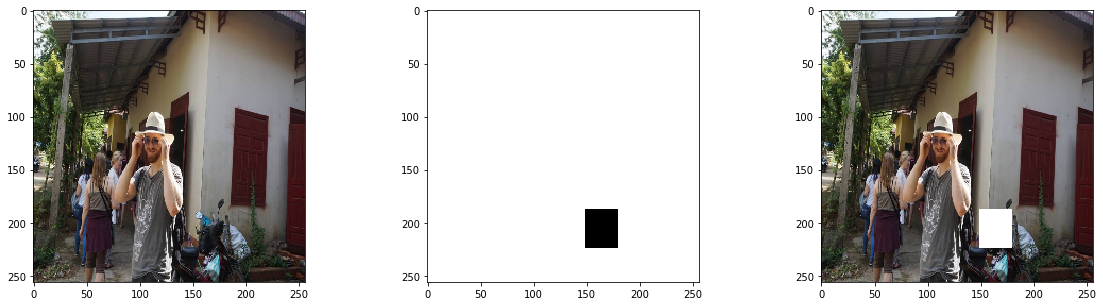

In [2]:
# Load image
img = cv2.imread('./data/sample_image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256)) / 255
shape = img.shape
print(f"Shape of image is: {shape}")

# Load mask
# mask = random_mask(shape[0], shape[1])

# Load single rect mask
mask = single_rect_mask(shape[0], shape[1])

# Image + mask
masked_img = deepcopy(img)
masked_img[mask==0] = 1

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask*255)
axes[2].imshow(masked_img)
plt.show()

## Creating data generator
In this simple testing case we'll only be testing the architecture on a single image to see how it performs. We create a generator that will infinitely yield the same image and masked_image for us. The generator is based off the ImageDataGenerator from keras.processing, which allows us to do all kinds of autmentation more easily. 

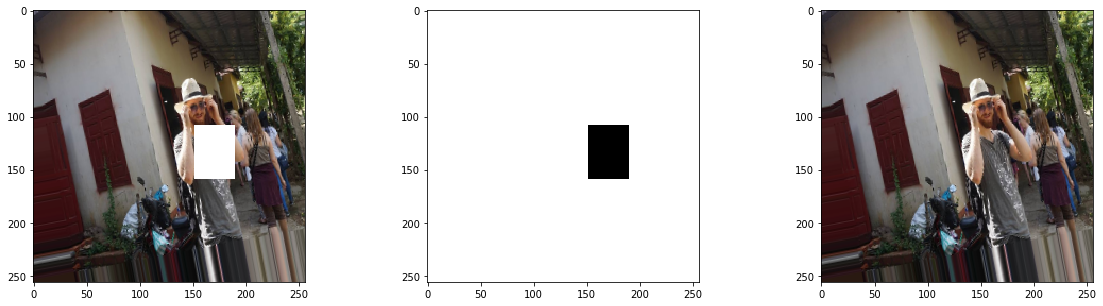

In [3]:
class DataGenerator(ImageDataGenerator):
    def flow(self, x, *args, **kwargs):
        while True:
            
            # Get augmentend image samples
            ori = next(super().flow(x, *args, **kwargs))

            # Get masks for each image sample
            # mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)
            
            # Get masks for each image sample
            mask = np.stack([single_rect_mask(ori.shape[1], ori.shape[2], ori.shape[3], max_rh=50, max_rw=50) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori        

# Create datagen
datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Create generator from numpy arrays
batch = np.stack([img for _ in range(MAX_BATCH_SIZE)], axis=0)
generator = datagen.flow(x=batch, batch_size=4)

# Get samples & Display them
(masked, mask), ori = next(generator)

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(masked[0,:,:,:])
axes[1].imshow(mask[0,:,:,:]*255)
axes[2].imshow(ori[0,:,:,:])

## Training classifier on single image

In [4]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')                
        plt.show()

Epoch 1/1


   1/1000 [..............................] - ETA: 2:54:26 - loss: 1181348.0000

   2/1000 [..............................] - ETA: 1:44:08 - loss: 1144980.3750

   3/1000 [..............................] - ETA: 1:20:36 - loss: 1099645.3958

   4/1000 [..............................] - ETA: 1:08:50 - loss: 1067928.2969

   5/1000 [..............................] - ETA: 1:01:45 - loss: 1049721.8375

   6/1000 [..............................] - ETA: 57:02 - loss: 1023211.4896  

   7/1000 [..............................] - ETA: 53:36 - loss: 1000409.6964

   8/1000 [..............................] - ETA: 51:03 - loss: 979436.8438 

   9/1000 [..............................] - ETA: 49:03 - loss: 958413.9861

  10/1000 [..............................] - ETA: 47:26 - loss: 934826.1687

  11/1000 [..............................] - ETA: 46:08 - loss: 915349.5398

  12/1000 [..............................] - ETA: 45:02 - loss: 893856.8281

  13/1000 [..............................] - ETA: 44:06 - loss: 873224.5433

  14/1000 [..............................] - ETA: 43:18 - loss: 853294.5714

  15/1000 [..............................] - ETA: 42:35 - loss: 835868.1958

  16/1000 [..............................] - ETA: 41:58 - loss: 821248.2383

  17/1000 [..............................] - ETA: 41:25 - loss: 808996.3235

  18/1000 [..............................] - ETA: 40:55 - loss: 792141.4010

  19/1000 [..............................] - ETA: 40:29 - loss: 780618.9260

  20/1000 [..............................] - ETA: 40:04 - loss: 768709.8359

  21/1000 [..............................] - ETA: 39:41 - loss: 758888.9062

  22/1000 [..............................] - ETA: 39:21 - loss: 747446.4460

  23/1000 [..............................] - ETA: 39:02 - loss: 736438.0910

  24/1000 [..............................] - ETA: 38:45 - loss: 726261.5352

  25/1000 [..............................] - ETA: 38:29 - loss: 715797.1025

  26/1000 [..............................] - ETA: 38:14 - loss: 706548.4291

  27/1000 [..............................] - ETA: 38:00 - loss: 697413.6759

  28/1000 [..............................] - ETA: 37:47 - loss: 689441.3504

  29/1000 [..............................] - ETA: 37:34 - loss: 680371.8351

  30/1000 [..............................] - ETA: 37:22 - loss: 673229.0656

  31/1000 [..............................] - ETA: 37:11 - loss: 666929.0433

  32/1000 [..............................] - ETA: 37:00 - loss: 659699.9580

  33/1000 [..............................] - ETA: 36:50 - loss: 652591.3532

  34/1000 [>.............................] - ETA: 36:40 - loss: 645498.2040

  35/1000 [>.............................] - ETA: 36:31 - loss: 639542.4437

  36/1000 [>.............................] - ETA: 36:23 - loss: 633069.3811

  37/1000 [>.............................] - ETA: 36:14 - loss: 627145.4916

  38/1000 [>.............................] - ETA: 36:06 - loss: 620996.7640

  39/1000 [>.............................] - ETA: 35:59 - loss: 615370.5657

  40/1000 [>.............................] - ETA: 35:51 - loss: 609506.3242

  41/1000 [>.............................] - ETA: 35:44 - loss: 604278.1860

  42/1000 [>.............................] - ETA: 35:37 - loss: 598976.5484

  43/1000 [>.............................] - ETA: 35:30 - loss: 593836.0545

  44/1000 [>.............................] - ETA: 35:24 - loss: 588565.4794

  45/1000 [>.............................] - ETA: 35:17 - loss: 584143.4472

  46/1000 [>.............................] - ETA: 35:11 - loss: 580266.7181

  47/1000 [>.............................] - ETA: 35:05 - loss: 576289.2826

  48/1000 [>.............................] - ETA: 34:59 - loss: 572357.8613

  49/1000 [>.............................] - ETA: 34:54 - loss: 568618.7366

  50/1000 [>.............................] - ETA: 34:48 - loss: 564810.5800

  51/1000 [>.............................] - ETA: 34:43 - loss: 560802.8873

  52/1000 [>.............................] - ETA: 34:37 - loss: 557105.9201

  53/1000 [>.............................] - ETA: 34:32 - loss: 553214.6203

  54/1000 [>.............................] - ETA: 34:27 - loss: 549536.1898

  55/1000 [>.............................] - ETA: 34:23 - loss: 546001.7818

  56/1000 [>.............................] - ETA: 34:18 - loss: 542212.9280

  57/1000 [>.............................] - ETA: 34:13 - loss: 538788.7533

  58/1000 [>.............................] - ETA: 34:09 - loss: 535417.7328

  59/1000 [>.............................] - ETA: 34:04 - loss: 532627.2892

  60/1000 [>.............................] - ETA: 34:00 - loss: 529684.3932

  61/1000 [>.............................] - ETA: 33:55 - loss: 526705.7351

  62/1000 [>.............................] - ETA: 33:51 - loss: 523789.7520

  63/1000 [>.............................] - ETA: 33:47 - loss: 521268.0977

  64/1000 [>.............................] - ETA: 33:43 - loss: 518679.8950

  65/1000 [>.............................] - ETA: 33:39 - loss: 515907.1394

  66/1000 [>.............................] - ETA: 33:35 - loss: 513528.5019

  67/1000 [=>............................] - ETA: 33:31 - loss: 510932.4468

  68/1000 [=>............................] - ETA: 33:27 - loss: 508196.2790

  69/1000 [=>............................] - ETA: 33:23 - loss: 505448.8537

  70/1000 [=>............................] - ETA: 33:19 - loss: 502882.0589

  71/1000 [=>............................] - ETA: 33:16 - loss: 499978.5871

  72/1000 [=>............................] - ETA: 33:12 - loss: 498090.6076

  73/1000 [=>............................] - ETA: 33:08 - loss: 495825.2063

  74/1000 [=>............................] - ETA: 33:05 - loss: 493510.7128

  75/1000 [=>............................] - ETA: 33:01 - loss: 491287.7950

  76/1000 [=>............................] - ETA: 32:57 - loss: 489187.3984

  77/1000 [=>............................] - ETA: 32:54 - loss: 487111.3003

  78/1000 [=>............................] - ETA: 32:50 - loss: 485164.4419

  79/1000 [=>............................] - ETA: 32:47 - loss: 483082.3319

  80/1000 [=>............................] - ETA: 32:44 - loss: 480937.8074

  81/1000 [=>............................] - ETA: 32:40 - loss: 478995.2045

  82/1000 [=>............................] - ETA: 32:37 - loss: 476801.5400

  83/1000 [=>............................] - ETA: 32:34 - loss: 474774.0907

  84/1000 [=>............................] - ETA: 32:31 - loss: 472695.2545

  85/1000 [=>............................] - ETA: 32:27 - loss: 470825.1485

  86/1000 [=>............................] - ETA: 32:24 - loss: 468980.7863

  87/1000 [=>............................] - ETA: 32:21 - loss: 467426.9264

  88/1000 [=>............................] - ETA: 32:18 - loss: 465628.8651

  89/1000 [=>............................] - ETA: 32:15 - loss: 463880.8834

  90/1000 [=>............................] - ETA: 32:12 - loss: 461979.1705

  91/1000 [=>............................] - ETA: 32:09 - loss: 460290.8111

  92/1000 [=>............................] - ETA: 32:06 - loss: 458888.6936

  93/1000 [=>............................] - ETA: 32:03 - loss: 457072.6862

  94/1000 [=>............................] - ETA: 32:00 - loss: 455725.8175

  95/1000 [=>............................] - ETA: 31:57 - loss: 453989.9609

  96/1000 [=>............................] - ETA: 31:54 - loss: 452541.2738

  97/1000 [=>............................] - ETA: 31:51 - loss: 451002.0741

  98/1000 [=>............................] - ETA: 31:48 - loss: 449588.2229

  99/1000 [=>............................] - ETA: 31:45 - loss: 448023.8005

 100/1000 [==>...........................] - ETA: 31:42 - loss: 446560.0322

 101/1000 [==>...........................] - ETA: 31:39 - loss: 445101.3320

 102/1000 [==>...........................] - ETA: 31:36 - loss: 443493.6057

 103/1000 [==>...........................] - ETA: 31:33 - loss: 442110.7233

 104/1000 [==>...........................] - ETA: 31:31 - loss: 440736.8522

 105/1000 [==>...........................] - ETA: 31:28 - loss: 439459.3354

 106/1000 [==>...........................] - ETA: 31:25 - loss: 438035.2780

 107/1000 [==>...........................] - ETA: 31:22 - loss: 436701.0561

 108/1000 [==>...........................] - ETA: 31:19 - loss: 435152.7535

 109/1000 [==>...........................] - ETA: 31:17 - loss: 433824.1376

 110/1000 [==>...........................] - ETA: 31:14 - loss: 432416.8545

 111/1000 [==>...........................] - ETA: 31:11 - loss: 431114.4513

 112/1000 [==>...........................] - ETA: 31:08 - loss: 429939.0625

 113/1000 [==>...........................] - ETA: 31:06 - loss: 428870.5957

 114/1000 [==>...........................] - ETA: 31:03 - loss: 427683.4737

 115/1000 [==>...........................] - ETA: 31:00 - loss: 426718.9280

 116/1000 [==>...........................] - ETA: 30:58 - loss: 425440.2465

 117/1000 [==>...........................] - ETA: 30:55 - loss: 424301.0187

 118/1000 [==>...........................] - ETA: 30:52 - loss: 423046.9012

 119/1000 [==>...........................] - ETA: 30:50 - loss: 421867.4701

 120/1000 [==>...........................] - ETA: 30:47 - loss: 420885.2266

 121/1000 [==>...........................] - ETA: 30:44 - loss: 419596.6333

 122/1000 [==>...........................] - ETA: 30:42 - loss: 418522.1114

 123/1000 [==>...........................] - ETA: 30:39 - loss: 417602.8986

 124/1000 [==>...........................] - ETA: 30:37 - loss: 416424.1789

 125/1000 [==>...........................] - ETA: 30:34 - loss: 415297.1375

 126/1000 [==>...........................] - ETA: 30:32 - loss: 414185.8410

 127/1000 [==>...........................] - ETA: 30:29 - loss: 413200.5795

 128/1000 [==>...........................] - ETA: 30:26 - loss: 412042.2649

 129/1000 [==>...........................] - ETA: 30:24 - loss: 410988.8830

 130/1000 [==>...........................] - ETA: 30:21 - loss: 410029.1678

 131/1000 [==>...........................] - ETA: 30:19 - loss: 409088.2994

 132/1000 [==>...........................] - ETA: 30:16 - loss: 408049.9060

 133/1000 [==>...........................] - ETA: 30:14 - loss: 407180.3438

 134/1000 [===>..........................] - ETA: 30:11 - loss: 405950.5842

 135/1000 [===>..........................] - ETA: 30:09 - loss: 404888.6620

 136/1000 [===>..........................] - ETA: 30:06 - loss: 403888.7923

 137/1000 [===>..........................] - ETA: 30:04 - loss: 402804.3618

 138/1000 [===>..........................] - ETA: 30:01 - loss: 401860.1825

 139/1000 [===>..........................] - ETA: 29:59 - loss: 400903.3961

 140/1000 [===>..........................] - ETA: 29:56 - loss: 400051.3799

 141/1000 [===>..........................] - ETA: 29:54 - loss: 399145.5434

 142/1000 [===>..........................] - ETA: 29:51 - loss: 398178.9914

 143/1000 [===>..........................] - ETA: 29:49 - loss: 397218.5616

 144/1000 [===>..........................] - ETA: 29:46 - loss: 396224.5852

 145/1000 [===>..........................] - ETA: 29:44 - loss: 395583.3096

 146/1000 [===>..........................] - ETA: 29:42 - loss: 394643.4577

 147/1000 [===>..........................] - ETA: 29:39 - loss: 393648.3260

 148/1000 [===>..........................] - ETA: 29:37 - loss: 392941.8935

 149/1000 [===>..........................] - ETA: 29:34 - loss: 392245.0658

 150/1000 [===>..........................] - ETA: 29:32 - loss: 391504.0957

 151/1000 [===>..........................] - ETA: 29:30 - loss: 390563.3807

 152/1000 [===>..........................] - ETA: 29:27 - loss: 389852.8352

 153/1000 [===>..........................] - ETA: 29:25 - loss: 388943.3386

 154/1000 [===>..........................] - ETA: 29:22 - loss: 387964.3029

 155/1000 [===>..........................] - ETA: 29:20 - loss: 387144.1873

 156/1000 [===>..........................] - ETA: 29:18 - loss: 386408.4239

 157/1000 [===>..........................] - ETA: 29:15 - loss: 385472.6929

 158/1000 [===>..........................] - ETA: 29:13 - loss: 384618.7726

 159/1000 [===>..........................] - ETA: 29:10 - loss: 383806.3957

 160/1000 [===>..........................] - ETA: 29:08 - loss: 382891.6315

 161/1000 [===>..........................] - ETA: 29:06 - loss: 382109.1164

 162/1000 [===>..........................] - ETA: 29:03 - loss: 381246.3313

 163/1000 [===>..........................] - ETA: 29:01 - loss: 380449.0666

 164/1000 [===>..........................] - ETA: 28:59 - loss: 379697.6612

 165/1000 [===>..........................] - ETA: 28:56 - loss: 379070.3794

 166/1000 [===>..........................] - ETA: 28:54 - loss: 378432.9032

 167/1000 [====>.........................] - ETA: 28:52 - loss: 377666.9264

 168/1000 [====>.........................] - ETA: 28:49 - loss: 376922.1661

 169/1000 [====>.........................] - ETA: 28:47 - loss: 376161.7645

 170/1000 [====>.........................] - ETA: 28:45 - loss: 375558.7266

 171/1000 [====>.........................] - ETA: 28:42 - loss: 374910.3060

 172/1000 [====>.........................] - ETA: 28:40 - loss: 374279.7828

 173/1000 [====>.........................] - ETA: 28:38 - loss: 373715.4952

 174/1000 [====>.........................] - ETA: 28:35 - loss: 373154.2858

 175/1000 [====>.........................] - ETA: 28:33 - loss: 372445.2171

 176/1000 [====>.........................] - ETA: 28:31 - loss: 371843.8722

 177/1000 [====>.........................] - ETA: 28:28 - loss: 371205.0162

 178/1000 [====>.........................] - ETA: 28:26 - loss: 370526.8610

 179/1000 [====>.........................] - ETA: 28:24 - loss: 369881.9441

 180/1000 [====>.........................] - ETA: 28:22 - loss: 369184.5804

 181/1000 [====>.........................] - ETA: 28:19 - loss: 368563.6474

 182/1000 [====>.........................] - ETA: 28:17 - loss: 367884.7629

 183/1000 [====>.........................] - ETA: 28:15 - loss: 367403.0540

 184/1000 [====>.........................] - ETA: 28:12 - loss: 366697.4219

 185/1000 [====>.........................] - ETA: 28:10 - loss: 366010.3640

 186/1000 [====>.........................] - ETA: 28:08 - loss: 365379.6401

 187/1000 [====>.........................] - ETA: 28:06 - loss: 364717.4886

 188/1000 [====>.........................] - ETA: 28:03 - loss: 364149.9663

 189/1000 [====>.........................] - ETA: 28:01 - loss: 363493.3153

 190/1000 [====>.........................] - ETA: 27:59 - loss: 362983.7337

 191/1000 [====>.........................] - ETA: 27:57 - loss: 362256.4606

 192/1000 [====>.........................] - ETA: 27:54 - loss: 361557.0745

 193/1000 [====>.........................] - ETA: 27:52 - loss: 360932.3245

 194/1000 [====>.........................] - ETA: 27:50 - loss: 360346.3603

 195/1000 [====>.........................] - ETA: 27:48 - loss: 359684.7564

 196/1000 [====>.........................] - ETA: 27:45 - loss: 359114.0268

 197/1000 [====>.........................] - ETA: 27:43 - loss: 358613.2496

 198/1000 [====>.........................] - ETA: 27:41 - loss: 358022.1734

 199/1000 [====>.........................] - ETA: 27:39 - loss: 357547.9875

 200/1000 [=====>........................] - ETA: 27:36 - loss: 357060.8407

 201/1000 [=====>........................] - ETA: 27:34 - loss: 356573.9857

 202/1000 [=====>........................] - ETA: 27:32 - loss: 355936.2985

 203/1000 [=====>........................] - ETA: 27:30 - loss: 355416.3924

 204/1000 [=====>........................] - ETA: 27:27 - loss: 354885.1122

 205/1000 [=====>........................] - ETA: 27:25 - loss: 354305.5527

 206/1000 [=====>........................] - ETA: 27:23 - loss: 353712.3324

 207/1000 [=====>........................] - ETA: 27:21 - loss: 353058.3709

 208/1000 [=====>........................] - ETA: 27:18 - loss: 352533.0506

 209/1000 [=====>........................] - ETA: 27:16 - loss: 352025.4008

 210/1000 [=====>........................] - ETA: 27:14 - loss: 351507.0263

 211/1000 [=====>........................] - ETA: 27:12 - loss: 350933.0582

 212/1000 [=====>........................] - ETA: 27:10 - loss: 350394.0678

 213/1000 [=====>........................] - ETA: 27:07 - loss: 349795.0522

 214/1000 [=====>........................] - ETA: 27:05 - loss: 349185.2860

 215/1000 [=====>........................] - ETA: 27:03 - loss: 348684.0632

 216/1000 [=====>........................] - ETA: 27:01 - loss: 348225.6128

 217/1000 [=====>........................] - ETA: 26:59 - loss: 347728.4484

 218/1000 [=====>........................] - ETA: 26:56 - loss: 347233.4631

 219/1000 [=====>........................] - ETA: 26:54 - loss: 346823.7620

 220/1000 [=====>........................] - ETA: 26:52 - loss: 346269.2854

 221/1000 [=====>........................] - ETA: 26:50 - loss: 345734.2435

 222/1000 [=====>........................] - ETA: 26:48 - loss: 345170.9141

 223/1000 [=====>........................] - ETA: 26:45 - loss: 344704.0511

 224/1000 [=====>........................] - ETA: 26:43 - loss: 344214.9590

 225/1000 [=====>........................] - ETA: 26:41 - loss: 343708.9175

 226/1000 [=====>........................] - ETA: 26:39 - loss: 343227.7303

 227/1000 [=====>........................] - ETA: 26:37 - loss: 342720.2551

 228/1000 [=====>........................] - ETA: 26:34 - loss: 342184.0207

 229/1000 [=====>........................] - ETA: 26:32 - loss: 341739.7014

 230/1000 [=====>........................] - ETA: 26:30 - loss: 341150.1498

 231/1000 [=====>........................] - ETA: 26:28 - loss: 340654.2472

 232/1000 [=====>........................] - ETA: 26:26 - loss: 340152.3669

 233/1000 [=====>........................] - ETA: 26:23 - loss: 339688.3627

 234/1000 [======>.......................] - ETA: 26:21 - loss: 339257.4784

 235/1000 [======>.......................] - ETA: 26:19 - loss: 338791.2297

 236/1000 [======>.......................] - ETA: 26:17 - loss: 338309.2018

 237/1000 [======>.......................] - ETA: 26:15 - loss: 337816.6921

 238/1000 [======>.......................] - ETA: 26:12 - loss: 337366.6737

 239/1000 [======>.......................] - ETA: 26:10 - loss: 336891.8074

 240/1000 [======>.......................] - ETA: 26:08 - loss: 336393.7720

 241/1000 [======>.......................] - ETA: 26:06 - loss: 335839.7962

 242/1000 [======>.......................] - ETA: 26:04 - loss: 335397.1836

 243/1000 [======>.......................] - ETA: 26:02 - loss: 335035.2142

 244/1000 [======>.......................] - ETA: 25:59 - loss: 334554.8305

 245/1000 [======>.......................] - ETA: 25:57 - loss: 334042.7418

 246/1000 [======>.......................] - ETA: 25:55 - loss: 333621.0596

 247/1000 [======>.......................] - ETA: 25:53 - loss: 333115.3317

 248/1000 [======>.......................] - ETA: 25:51 - loss: 332658.2761

 249/1000 [======>.......................] - ETA: 25:49 - loss: 332172.4494

 250/1000 [======>.......................] - ETA: 25:46 - loss: 331732.0751

 251/1000 [======>.......................] - ETA: 25:44 - loss: 331261.4260

 252/1000 [======>.......................] - ETA: 25:42 - loss: 330836.0959

 253/1000 [======>.......................] - ETA: 25:40 - loss: 330395.2299

 254/1000 [======>.......................] - ETA: 25:38 - loss: 329973.0044

 255/1000 [======>.......................] - ETA: 25:36 - loss: 329586.2396

 256/1000 [======>.......................] - ETA: 25:33 - loss: 329156.3621

 257/1000 [======>.......................] - ETA: 25:31 - loss: 328740.1361

 258/1000 [======>.......................] - ETA: 25:29 - loss: 328313.0880

 259/1000 [======>.......................] - ETA: 25:27 - loss: 327885.3849

 260/1000 [======>.......................] - ETA: 25:25 - loss: 327492.9232

 261/1000 [======>.......................] - ETA: 25:23 - loss: 327084.7548

 262/1000 [======>.......................] - ETA: 25:20 - loss: 326702.8482

 263/1000 [======>.......................] - ETA: 25:18 - loss: 326357.5948

 264/1000 [======>.......................] - ETA: 25:16 - loss: 325938.0221

 265/1000 [======>.......................] - ETA: 25:14 - loss: 325536.0978

 266/1000 [======>.......................] - ETA: 25:12 - loss: 325143.3332

 267/1000 [=======>......................] - ETA: 25:10 - loss: 324752.5214

 268/1000 [=======>......................] - ETA: 25:08 - loss: 324307.4161

 269/1000 [=======>......................] - ETA: 25:05 - loss: 323907.1975

 270/1000 [=======>......................] - ETA: 25:03 - loss: 323500.2285

 271/1000 [=======>......................] - ETA: 25:01 - loss: 323098.5574

 272/1000 [=======>......................] - ETA: 24:59 - loss: 322706.2092

 273/1000 [=======>......................] - ETA: 24:57 - loss: 322304.9848

 274/1000 [=======>......................] - ETA: 24:55 - loss: 321875.7064

 275/1000 [=======>......................] - ETA: 24:52 - loss: 321440.0338

 276/1000 [=======>......................] - ETA: 24:50 - loss: 321013.3726

 277/1000 [=======>......................] - ETA: 24:48 - loss: 320708.2819

 278/1000 [=======>......................] - ETA: 24:46 - loss: 320229.8440

 279/1000 [=======>......................] - ETA: 24:44 - loss: 319860.4783

 280/1000 [=======>......................] - ETA: 24:42 - loss: 319430.3945

 281/1000 [=======>......................] - ETA: 24:40 - loss: 319041.7923

 282/1000 [=======>......................] - ETA: 24:38 - loss: 318615.8182

 283/1000 [=======>......................] - ETA: 24:35 - loss: 318212.3913

 284/1000 [=======>......................] - ETA: 24:33 - loss: 317787.8189

 285/1000 [=======>......................] - ETA: 24:31 - loss: 317461.5882

 286/1000 [=======>......................] - ETA: 24:29 - loss: 317199.0691

 287/1000 [=======>......................] - ETA: 24:27 - loss: 316864.7611

 288/1000 [=======>......................] - ETA: 24:25 - loss: 316489.3658

 289/1000 [=======>......................] - ETA: 24:23 - loss: 316132.8641

 290/1000 [=======>......................] - ETA: 24:20 - loss: 315819.4979

 291/1000 [=======>......................] - ETA: 24:18 - loss: 315530.0252

 292/1000 [=======>......................] - ETA: 24:16 - loss: 315163.9708

 293/1000 [=======>......................] - ETA: 24:14 - loss: 314789.6843

 294/1000 [=======>......................] - ETA: 24:12 - loss: 314408.3767

 295/1000 [=======>......................] - ETA: 24:10 - loss: 314015.7207

 296/1000 [=======>......................] - ETA: 24:08 - loss: 313689.2913

 297/1000 [=======>......................] - ETA: 24:06 - loss: 313311.9581

 298/1000 [=======>......................] - ETA: 24:03 - loss: 312939.9573

 299/1000 [=======>......................] - ETA: 24:01 - loss: 312620.9031

 300/1000 [========>.....................] - ETA: 23:59 - loss: 312312.0947

 301/1000 [========>.....................] - ETA: 23:57 - loss: 311999.6547

 302/1000 [========>.....................] - ETA: 23:55 - loss: 311682.5626

 303/1000 [========>.....................] - ETA: 23:53 - loss: 311335.4217

 304/1000 [========>.....................] - ETA: 23:51 - loss: 310971.9582

 305/1000 [========>.....................] - ETA: 23:49 - loss: 310611.8782

 306/1000 [========>.....................] - ETA: 23:46 - loss: 310355.7383

 307/1000 [========>.....................] - ETA: 23:44 - loss: 309970.8689

 308/1000 [========>.....................] - ETA: 23:42 - loss: 309653.7750

 309/1000 [========>.....................] - ETA: 23:40 - loss: 309261.3398

 310/1000 [========>.....................] - ETA: 23:38 - loss: 308928.4665

 311/1000 [========>.....................] - ETA: 23:36 - loss: 308577.5923

 312/1000 [========>.....................] - ETA: 23:34 - loss: 308313.6301

 313/1000 [========>.....................] - ETA: 23:32 - loss: 308007.0565

 314/1000 [========>.....................] - ETA: 23:30 - loss: 307679.3908

 315/1000 [========>.....................] - ETA: 23:27 - loss: 307473.2341

 316/1000 [========>.....................] - ETA: 23:25 - loss: 307165.4366

 317/1000 [========>.....................] - ETA: 23:23 - loss: 306915.5232

 318/1000 [========>.....................] - ETA: 23:21 - loss: 306571.0309

 319/1000 [========>.....................] - ETA: 23:19 - loss: 306237.8611

 320/1000 [========>.....................] - ETA: 23:17 - loss: 305997.5584

 321/1000 [========>.....................] - ETA: 23:15 - loss: 305721.2065

 322/1000 [========>.....................] - ETA: 23:13 - loss: 305354.9562

 323/1000 [========>.....................] - ETA: 23:11 - loss: 305050.1551

 324/1000 [========>.....................] - ETA: 23:08 - loss: 304718.2362

 325/1000 [========>.....................] - ETA: 23:06 - loss: 304404.1226

 326/1000 [========>.....................] - ETA: 23:04 - loss: 304147.5957

 327/1000 [========>.....................] - ETA: 23:02 - loss: 303810.4992

 328/1000 [========>.....................] - ETA: 23:00 - loss: 303554.5968

 329/1000 [========>.....................] - ETA: 22:58 - loss: 303243.4013

 330/1000 [========>.....................] - ETA: 22:56 - loss: 302950.6403

 331/1000 [========>.....................] - ETA: 22:54 - loss: 302620.2747

 332/1000 [========>.....................] - ETA: 22:52 - loss: 302279.2505

 333/1000 [========>.....................] - ETA: 22:49 - loss: 301967.9797

 334/1000 [=========>....................] - ETA: 22:47 - loss: 301622.0190

 335/1000 [=========>....................] - ETA: 22:45 - loss: 301268.1789

 336/1000 [=========>....................] - ETA: 22:43 - loss: 300978.0539

 337/1000 [=========>....................] - ETA: 22:41 - loss: 300673.3542

 338/1000 [=========>....................] - ETA: 22:39 - loss: 300382.1924

 339/1000 [=========>....................] - ETA: 22:37 - loss: 300071.8969

 340/1000 [=========>....................] - ETA: 22:35 - loss: 299779.1649

 341/1000 [=========>....................] - ETA: 22:33 - loss: 299473.6685

 342/1000 [=========>....................] - ETA: 22:31 - loss: 299216.4246

 343/1000 [=========>....................] - ETA: 22:28 - loss: 298912.2582

 344/1000 [=========>....................] - ETA: 22:26 - loss: 298661.6552

 345/1000 [=========>....................] - ETA: 22:24 - loss: 298346.2163

 346/1000 [=========>....................] - ETA: 22:22 - loss: 298021.3274

 347/1000 [=========>....................] - ETA: 22:20 - loss: 297712.8194

 348/1000 [=========>....................] - ETA: 22:18 - loss: 297406.9642

 349/1000 [=========>....................] - ETA: 22:16 - loss: 297119.5154

 350/1000 [=========>....................] - ETA: 22:14 - loss: 296836.6791

 351/1000 [=========>....................] - ETA: 22:12 - loss: 296535.5395

 352/1000 [=========>....................] - ETA: 22:10 - loss: 296325.7770

 353/1000 [=========>....................] - ETA: 22:07 - loss: 296061.4822

 354/1000 [=========>....................] - ETA: 22:05 - loss: 295763.8488

 355/1000 [=========>....................] - ETA: 22:03 - loss: 295462.5060

 356/1000 [=========>....................] - ETA: 22:01 - loss: 295205.7893

 357/1000 [=========>....................] - ETA: 21:59 - loss: 294955.1246

 358/1000 [=========>....................] - ETA: 21:57 - loss: 294643.9749

 359/1000 [=========>....................] - ETA: 21:55 - loss: 294377.1464

 360/1000 [=========>....................] - ETA: 21:53 - loss: 294057.5304

 361/1000 [=========>....................] - ETA: 21:51 - loss: 293796.7717

 362/1000 [=========>....................] - ETA: 21:49 - loss: 293476.3704

 363/1000 [=========>....................] - ETA: 21:47 - loss: 293174.4329

 364/1000 [=========>....................] - ETA: 21:44 - loss: 292922.5375

 365/1000 [=========>....................] - ETA: 21:42 - loss: 292629.9611

 366/1000 [=========>....................] - ETA: 21:40 - loss: 292418.2055

 367/1000 [==========>...................] - ETA: 21:38 - loss: 292149.1713

 368/1000 [==========>...................] - ETA: 21:36 - loss: 291853.9558

 369/1000 [==========>...................] - ETA: 21:34 - loss: 291615.4272

 370/1000 [==========>...................] - ETA: 21:32 - loss: 291329.6025

 371/1000 [==========>...................] - ETA: 21:30 - loss: 291069.2217

 372/1000 [==========>...................] - ETA: 21:28 - loss: 290814.3415

 373/1000 [==========>...................] - ETA: 21:26 - loss: 290542.4390

 374/1000 [==========>...................] - ETA: 21:24 - loss: 290284.9261

 375/1000 [==========>...................] - ETA: 21:21 - loss: 290034.8403

 376/1000 [==========>...................] - ETA: 21:19 - loss: 289768.1036

 377/1000 [==========>...................] - ETA: 21:17 - loss: 289578.5914

 378/1000 [==========>...................] - ETA: 21:15 - loss: 289323.5567

 379/1000 [==========>...................] - ETA: 21:13 - loss: 289053.1949

 380/1000 [==========>...................] - ETA: 21:11 - loss: 288851.1363

 381/1000 [==========>...................] - ETA: 21:09 - loss: 288590.1323

 382/1000 [==========>...................] - ETA: 21:07 - loss: 288315.1103

 383/1000 [==========>...................] - ETA: 21:05 - loss: 288062.4105

 384/1000 [==========>...................] - ETA: 21:03 - loss: 287788.0475

 385/1000 [==========>...................] - ETA: 21:01 - loss: 287521.9450

 386/1000 [==========>...................] - ETA: 20:58 - loss: 287320.4522

 387/1000 [==========>...................] - ETA: 20:56 - loss: 287110.1947

 388/1000 [==========>...................] - ETA: 20:54 - loss: 286804.6602

 389/1000 [==========>...................] - ETA: 20:52 - loss: 286533.1934

 390/1000 [==========>...................] - ETA: 20:50 - loss: 286305.2107

 391/1000 [==========>...................] - ETA: 20:48 - loss: 286075.6147

 392/1000 [==========>...................] - ETA: 20:46 - loss: 285854.3437

 393/1000 [==========>...................] - ETA: 20:44 - loss: 285662.0248

 394/1000 [==========>...................] - ETA: 20:42 - loss: 285478.1598

 395/1000 [==========>...................] - ETA: 20:40 - loss: 285201.4788

 396/1000 [==========>...................] - ETA: 20:38 - loss: 284977.5310

 397/1000 [==========>...................] - ETA: 20:35 - loss: 284698.6573

 398/1000 [==========>...................] - ETA: 20:33 - loss: 284455.1099

 399/1000 [==========>...................] - ETA: 20:31 - loss: 284197.1335

 400/1000 [===========>..................] - ETA: 20:29 - loss: 283969.7671

 401/1000 [===========>..................] - ETA: 20:27 - loss: 283717.6838

 402/1000 [===========>..................] - ETA: 20:25 - loss: 283475.9475

 403/1000 [===========>..................] - ETA: 20:23 - loss: 283268.3976

 404/1000 [===========>..................] - ETA: 20:21 - loss: 282989.1096

 405/1000 [===========>..................] - ETA: 20:19 - loss: 282718.2760

 406/1000 [===========>..................] - ETA: 20:17 - loss: 282474.7491

 407/1000 [===========>..................] - ETA: 20:15 - loss: 282251.5210

 408/1000 [===========>..................] - ETA: 20:13 - loss: 282048.4428

 409/1000 [===========>..................] - ETA: 20:10 - loss: 281848.8206

 410/1000 [===========>..................] - ETA: 20:08 - loss: 281560.7768

 411/1000 [===========>..................] - ETA: 20:06 - loss: 281368.5422

 412/1000 [===========>..................] - ETA: 20:04 - loss: 281109.2599

 413/1000 [===========>..................] - ETA: 20:02 - loss: 280886.8542

 414/1000 [===========>..................] - ETA: 20:00 - loss: 280665.5830

 415/1000 [===========>..................] - ETA: 19:58 - loss: 280430.1712

 416/1000 [===========>..................] - ETA: 19:56 - loss: 280142.1620

 417/1000 [===========>..................] - ETA: 19:54 - loss: 279927.1157

 418/1000 [===========>..................] - ETA: 19:52 - loss: 279672.6210

 419/1000 [===========>..................] - ETA: 19:50 - loss: 279421.9115

 420/1000 [===========>..................] - ETA: 19:48 - loss: 279164.2315

 421/1000 [===========>..................] - ETA: 19:46 - loss: 278916.9631

 422/1000 [===========>..................] - ETA: 19:43 - loss: 278698.1658

 423/1000 [===========>..................] - ETA: 19:41 - loss: 278426.1068

 424/1000 [===========>..................] - ETA: 19:39 - loss: 278133.5696

 425/1000 [===========>..................] - ETA: 19:37 - loss: 277949.4736

 426/1000 [===========>..................] - ETA: 19:35 - loss: 277786.0448

 427/1000 [===========>..................] - ETA: 19:33 - loss: 277530.5308

 428/1000 [===========>..................] - ETA: 19:31 - loss: 277319.7970

 429/1000 [===========>..................] - ETA: 19:29 - loss: 277061.0027

 430/1000 [===========>..................] - ETA: 19:27 - loss: 276857.5854

 431/1000 [===========>..................] - ETA: 19:25 - loss: 276614.4073

 432/1000 [===========>..................] - ETA: 19:23 - loss: 276355.3684

 433/1000 [===========>..................] - ETA: 19:21 - loss: 276145.4543

 434/1000 [============>.................] - ETA: 19:19 - loss: 275883.7651

 435/1000 [============>.................] - ETA: 19:16 - loss: 275657.1127

 436/1000 [============>.................] - ETA: 19:14 - loss: 275410.6194

 437/1000 [============>.................] - ETA: 19:12 - loss: 275192.6529

 438/1000 [============>.................] - ETA: 19:10 - loss: 274972.2784

 439/1000 [============>.................] - ETA: 19:08 - loss: 274801.9925

 440/1000 [============>.................] - ETA: 19:06 - loss: 274587.1715

 441/1000 [============>.................] - ETA: 19:04 - loss: 274389.1807

 442/1000 [============>.................] - ETA: 19:02 - loss: 274159.1625

 443/1000 [============>.................] - ETA: 19:00 - loss: 273968.0964

 444/1000 [============>.................] - ETA: 18:58 - loss: 273715.1743

 445/1000 [============>.................] - ETA: 18:56 - loss: 273497.4295

 446/1000 [============>.................] - ETA: 18:54 - loss: 273246.8906

 447/1000 [============>.................] - ETA: 18:52 - loss: 273075.3014

 448/1000 [============>.................] - ETA: 18:50 - loss: 272845.0485

 449/1000 [============>.................] - ETA: 18:47 - loss: 272617.7011

 450/1000 [============>.................] - ETA: 18:45 - loss: 272383.8195

 451/1000 [============>.................] - ETA: 18:43 - loss: 272177.3990

 452/1000 [============>.................] - ETA: 18:41 - loss: 271968.2759

 453/1000 [============>.................] - ETA: 18:39 - loss: 271758.6856

 454/1000 [============>.................] - ETA: 18:37 - loss: 271568.1783

 455/1000 [============>.................] - ETA: 18:35 - loss: 271351.4615

 456/1000 [============>.................] - ETA: 18:33 - loss: 271137.3218

 457/1000 [============>.................] - ETA: 18:31 - loss: 270894.2969

 458/1000 [============>.................] - ETA: 18:29 - loss: 270667.6663

 459/1000 [============>.................] - ETA: 18:27 - loss: 270472.9715

 460/1000 [============>.................] - ETA: 18:25 - loss: 270266.6923

 461/1000 [============>.................] - ETA: 18:23 - loss: 270064.1603

 462/1000 [============>.................] - ETA: 18:21 - loss: 269844.8640

 463/1000 [============>.................] - ETA: 18:19 - loss: 269627.9381

 464/1000 [============>.................] - ETA: 18:16 - loss: 269392.5731

 465/1000 [============>.................] - ETA: 18:14 - loss: 269190.4207

 466/1000 [============>.................] - ETA: 18:12 - loss: 268992.5017

 467/1000 [=============>................] - ETA: 18:10 - loss: 268789.0083

 468/1000 [=============>................] - ETA: 18:08 - loss: 268550.6126

 469/1000 [=============>................] - ETA: 18:06 - loss: 268328.6837

 470/1000 [=============>................] - ETA: 18:04 - loss: 268110.0563

 471/1000 [=============>................] - ETA: 18:02 - loss: 267871.2669

 472/1000 [=============>................] - ETA: 18:00 - loss: 267707.1924

 473/1000 [=============>................] - ETA: 17:58 - loss: 267545.5164

 474/1000 [=============>................] - ETA: 17:56 - loss: 267309.1045

 475/1000 [=============>................] - ETA: 17:54 - loss: 267097.8389

 476/1000 [=============>................] - ETA: 17:52 - loss: 266923.8681

 477/1000 [=============>................] - ETA: 17:50 - loss: 266702.2287

 478/1000 [=============>................] - ETA: 17:48 - loss: 266473.4634

 479/1000 [=============>................] - ETA: 17:45 - loss: 266260.1474

 480/1000 [=============>................] - ETA: 17:43 - loss: 266034.2479

 481/1000 [=============>................] - ETA: 17:41 - loss: 265830.3173

 482/1000 [=============>................] - ETA: 17:39 - loss: 265589.0972

 483/1000 [=============>................] - ETA: 17:37 - loss: 265394.4414

 484/1000 [=============>................] - ETA: 17:35 - loss: 265175.1082

 485/1000 [=============>................] - ETA: 17:33 - loss: 264955.0805

 486/1000 [=============>................] - ETA: 17:31 - loss: 264787.6746

 487/1000 [=============>................] - ETA: 17:29 - loss: 264610.4614

 488/1000 [=============>................] - ETA: 17:27 - loss: 264464.8405

 489/1000 [=============>................] - ETA: 17:25 - loss: 264253.3209

 490/1000 [=============>................] - ETA: 17:23 - loss: 264046.1949

 491/1000 [=============>................] - ETA: 17:21 - loss: 263820.9142

 492/1000 [=============>................] - ETA: 17:19 - loss: 263622.6623

 493/1000 [=============>................] - ETA: 17:17 - loss: 263387.5560

 494/1000 [=============>................] - ETA: 17:15 - loss: 263189.5262

 495/1000 [=============>................] - ETA: 17:12 - loss: 262997.9693

 496/1000 [=============>................] - ETA: 17:10 - loss: 262798.2793

 497/1000 [=============>................] - ETA: 17:08 - loss: 262587.9004

 498/1000 [=============>................] - ETA: 17:06 - loss: 262390.8367

 499/1000 [=============>................] - ETA: 17:04 - loss: 262171.2965

 500/1000 [==============>...............] - ETA: 17:02 - loss: 262000.2531

 501/1000 [==============>...............] - ETA: 17:00 - loss: 261807.6800

 502/1000 [==============>...............] - ETA: 16:58 - loss: 261605.1416

 503/1000 [==============>...............] - ETA: 16:56 - loss: 261416.6560

 504/1000 [==============>...............] - ETA: 16:54 - loss: 261309.6616

 505/1000 [==============>...............] - ETA: 16:52 - loss: 261129.0517

 506/1000 [==============>...............] - ETA: 16:50 - loss: 260936.7194

 507/1000 [==============>...............] - ETA: 16:48 - loss: 260737.5236

 508/1000 [==============>...............] - ETA: 16:46 - loss: 260543.1630

 509/1000 [==============>...............] - ETA: 16:44 - loss: 260375.4683

 510/1000 [==============>...............] - ETA: 16:42 - loss: 260210.5170

 511/1000 [==============>...............] - ETA: 16:39 - loss: 260045.3634

 512/1000 [==============>...............] - ETA: 16:37 - loss: 259851.9212

 513/1000 [==============>...............] - ETA: 16:35 - loss: 259672.2388

 514/1000 [==============>...............] - ETA: 16:33 - loss: 259507.6342

 515/1000 [==============>...............] - ETA: 16:31 - loss: 259359.6100

 516/1000 [==============>...............] - ETA: 16:29 - loss: 259202.4211

 517/1000 [==============>...............] - ETA: 16:27 - loss: 259056.3320

 518/1000 [==============>...............] - ETA: 16:25 - loss: 258917.3076

 519/1000 [==============>...............] - ETA: 16:23 - loss: 258859.5744

 520/1000 [==============>...............] - ETA: 16:21 - loss: 258738.0289

 521/1000 [==============>...............] - ETA: 16:19 - loss: 258578.1880

 522/1000 [==============>...............] - ETA: 16:17 - loss: 258411.1042

 523/1000 [==============>...............] - ETA: 16:15 - loss: 258245.2371

 524/1000 [==============>...............] - ETA: 16:13 - loss: 258079.3629

 525/1000 [==============>...............] - ETA: 16:11 - loss: 257925.2012

 526/1000 [==============>...............] - ETA: 16:09 - loss: 257766.9698

 527/1000 [==============>...............] - ETA: 16:06 - loss: 257596.0592

 528/1000 [==============>...............] - ETA: 16:04 - loss: 257415.8306

 529/1000 [==============>...............] - ETA: 16:02 - loss: 257250.2932

 530/1000 [==============>...............] - ETA: 16:00 - loss: 257053.5674

 531/1000 [==============>...............] - ETA: 15:58 - loss: 256882.0252

 532/1000 [==============>...............] - ETA: 15:56 - loss: 256678.8850

 533/1000 [==============>...............] - ETA: 15:54 - loss: 256498.9700

 534/1000 [===============>..............] - ETA: 15:52 - loss: 256330.3514

 535/1000 [===============>..............] - ETA: 15:50 - loss: 256163.9010

 536/1000 [===============>..............] - ETA: 15:48 - loss: 255975.5312

 537/1000 [===============>..............] - ETA: 15:46 - loss: 255807.6710

 538/1000 [===============>..............] - ETA: 15:44 - loss: 255651.3821

 539/1000 [===============>..............] - ETA: 15:42 - loss: 255474.7096

 540/1000 [===============>..............] - ETA: 15:40 - loss: 255296.7858

 541/1000 [===============>..............] - ETA: 15:38 - loss: 255186.6186

 542/1000 [===============>..............] - ETA: 15:36 - loss: 255029.0803

 543/1000 [===============>..............] - ETA: 15:34 - loss: 254849.1297

 544/1000 [===============>..............] - ETA: 15:31 - loss: 254709.5246

 545/1000 [===============>..............] - ETA: 15:29 - loss: 254608.1266

 546/1000 [===============>..............] - ETA: 15:27 - loss: 254452.5645

 547/1000 [===============>..............] - ETA: 15:25 - loss: 254340.4751

 548/1000 [===============>..............] - ETA: 15:23 - loss: 254172.5847

 549/1000 [===============>..............] - ETA: 15:21 - loss: 254021.8008

 550/1000 [===============>..............] - ETA: 15:19 - loss: 253831.5727

 551/1000 [===============>..............] - ETA: 15:17 - loss: 253654.5335

 552/1000 [===============>..............] - ETA: 15:15 - loss: 253515.0710

 553/1000 [===============>..............] - ETA: 15:13 - loss: 253352.0900

 554/1000 [===============>..............] - ETA: 15:11 - loss: 253170.1054

 555/1000 [===============>..............] - ETA: 15:09 - loss: 252979.7462

 556/1000 [===============>..............] - ETA: 15:07 - loss: 252837.3946

 557/1000 [===============>..............] - ETA: 15:05 - loss: 252648.1852

 558/1000 [===============>..............] - ETA: 15:03 - loss: 252477.7968

 559/1000 [===============>..............] - ETA: 15:01 - loss: 252330.4536

 560/1000 [===============>..............] - ETA: 14:59 - loss: 252173.5328

 561/1000 [===============>..............] - ETA: 14:57 - loss: 251996.4099

 562/1000 [===============>..............] - ETA: 14:55 - loss: 251857.6941

 563/1000 [===============>..............] - ETA: 14:52 - loss: 251695.9013

 564/1000 [===============>..............] - ETA: 14:50 - loss: 251529.9600

 565/1000 [===============>..............] - ETA: 14:48 - loss: 251372.3228

 566/1000 [===============>..............] - ETA: 14:46 - loss: 251247.4069

 567/1000 [================>.............] - ETA: 14:44 - loss: 251100.3557

 568/1000 [================>.............] - ETA: 14:42 - loss: 250973.4102

 569/1000 [================>.............] - ETA: 14:40 - loss: 250839.8504

 570/1000 [================>.............] - ETA: 14:38 - loss: 250724.2441

 571/1000 [================>.............] - ETA: 14:36 - loss: 250632.3196

 572/1000 [================>.............] - ETA: 14:34 - loss: 250490.6409

 573/1000 [================>.............] - ETA: 14:32 - loss: 250296.3585

 574/1000 [================>.............] - ETA: 14:30 - loss: 250166.3450

 575/1000 [================>.............] - ETA: 14:28 - loss: 250004.4305

 576/1000 [================>.............] - ETA: 14:26 - loss: 249859.5544

 577/1000 [================>.............] - ETA: 14:24 - loss: 249772.5834

 578/1000 [================>.............] - ETA: 14:22 - loss: 249668.5428

 579/1000 [================>.............] - ETA: 14:20 - loss: 249546.5962

 580/1000 [================>.............] - ETA: 14:18 - loss: 249419.0198

 581/1000 [================>.............] - ETA: 14:15 - loss: 249271.0696

 582/1000 [================>.............] - ETA: 14:13 - loss: 249172.2490

 583/1000 [================>.............] - ETA: 14:11 - loss: 249070.7484

 584/1000 [================>.............] - ETA: 14:09 - loss: 248935.1789

 585/1000 [================>.............] - ETA: 14:07 - loss: 248825.5813

 586/1000 [================>.............] - ETA: 14:05 - loss: 248735.8100

 587/1000 [================>.............] - ETA: 14:03 - loss: 248610.3351

 588/1000 [================>.............] - ETA: 14:01 - loss: 248482.9921

 589/1000 [================>.............] - ETA: 13:59 - loss: 248323.2920

 590/1000 [================>.............] - ETA: 13:57 - loss: 248201.0845

 591/1000 [================>.............] - ETA: 13:55 - loss: 248086.7353

 592/1000 [================>.............] - ETA: 13:53 - loss: 247944.2083

 593/1000 [================>.............] - ETA: 13:51 - loss: 247805.3088

 594/1000 [================>.............] - ETA: 13:49 - loss: 247652.7485

 595/1000 [================>.............] - ETA: 13:47 - loss: 247519.4373

 596/1000 [================>.............] - ETA: 13:45 - loss: 247382.5644

 597/1000 [================>.............] - ETA: 13:43 - loss: 247269.2445

 598/1000 [================>.............] - ETA: 13:41 - loss: 247114.3182

 599/1000 [================>.............] - ETA: 13:39 - loss: 246954.2285

 600/1000 [=================>............] - ETA: 13:36 - loss: 246850.4854

 601/1000 [=================>............] - ETA: 13:34 - loss: 246703.3980

 602/1000 [=================>............] - ETA: 13:32 - loss: 246563.3837

 603/1000 [=================>............] - ETA: 13:30 - loss: 246429.2585

 604/1000 [=================>............] - ETA: 13:28 - loss: 246281.2527

 605/1000 [=================>............] - ETA: 13:26 - loss: 246121.6468

 606/1000 [=================>............] - ETA: 13:24 - loss: 245960.4285

 607/1000 [=================>............] - ETA: 13:22 - loss: 245831.9754

 608/1000 [=================>............] - ETA: 13:20 - loss: 245649.5787

 609/1000 [=================>............] - ETA: 13:18 - loss: 245503.0536

 610/1000 [=================>............] - ETA: 13:16 - loss: 245371.3587

 611/1000 [=================>............] - ETA: 13:14 - loss: 245218.0226

 612/1000 [=================>............] - ETA: 13:12 - loss: 245034.1490

 613/1000 [=================>............] - ETA: 13:10 - loss: 244888.6379

 614/1000 [=================>............] - ETA: 13:08 - loss: 244725.3794

 615/1000 [=================>............] - ETA: 13:06 - loss: 244552.9831

 616/1000 [=================>............] - ETA: 13:04 - loss: 244404.2241

 617/1000 [=================>............] - ETA: 13:02 - loss: 244241.1762

 618/1000 [=================>............] - ETA: 13:00 - loss: 244078.3858

 619/1000 [=================>............] - ETA: 12:57 - loss: 243926.6267

 620/1000 [=================>............] - ETA: 12:55 - loss: 243790.2827

 621/1000 [=================>............] - ETA: 12:53 - loss: 243626.7181

 622/1000 [=================>............] - ETA: 12:51 - loss: 243477.2818

 623/1000 [=================>............] - ETA: 12:49 - loss: 243335.6703

 624/1000 [=================>............] - ETA: 12:47 - loss: 243188.0273

 625/1000 [=================>............] - ETA: 12:45 - loss: 243074.2025

 626/1000 [=================>............] - ETA: 12:43 - loss: 242940.7180

 627/1000 [=================>............] - ETA: 12:41 - loss: 242787.9030

 628/1000 [=================>............] - ETA: 12:39 - loss: 242665.2909

 629/1000 [=================>............] - ETA: 12:37 - loss: 242554.1187

 630/1000 [=================>............] - ETA: 12:35 - loss: 242378.2003

 631/1000 [=================>............] - ETA: 12:33 - loss: 242266.9478

 632/1000 [=================>............] - ETA: 12:31 - loss: 242128.7212

 633/1000 [=================>............] - ETA: 12:29 - loss: 241977.9551

 634/1000 [==================>...........] - ETA: 12:27 - loss: 241847.9666

 635/1000 [==================>...........] - ETA: 12:25 - loss: 241686.4392

 636/1000 [==================>...........] - ETA: 12:23 - loss: 241550.3389

 637/1000 [==================>...........] - ETA: 12:21 - loss: 241430.3745

 638/1000 [==================>...........] - ETA: 12:19 - loss: 241317.3099

 639/1000 [==================>...........] - ETA: 12:16 - loss: 241169.8825

 640/1000 [==================>...........] - ETA: 12:14 - loss: 241030.8526

 641/1000 [==================>...........] - ETA: 12:12 - loss: 240913.1293

 642/1000 [==================>...........] - ETA: 12:10 - loss: 240822.0681

 643/1000 [==================>...........] - ETA: 12:08 - loss: 240689.3788

 644/1000 [==================>...........] - ETA: 12:06 - loss: 240544.9196

 645/1000 [==================>...........] - ETA: 12:04 - loss: 240416.7446

 646/1000 [==================>...........] - ETA: 12:02 - loss: 240264.1478

 647/1000 [==================>...........] - ETA: 12:00 - loss: 240107.1388

 648/1000 [==================>...........] - ETA: 11:58 - loss: 239985.0020

 649/1000 [==================>...........] - ETA: 11:56 - loss: 239863.1859

 650/1000 [==================>...........] - ETA: 11:54 - loss: 239775.5092

 651/1000 [==================>...........] - ETA: 11:52 - loss: 239643.5112

 652/1000 [==================>...........] - ETA: 11:50 - loss: 239515.7903

 653/1000 [==================>...........] - ETA: 11:48 - loss: 239386.2376

 654/1000 [==================>...........] - ETA: 11:46 - loss: 239240.5895

 655/1000 [==================>...........] - ETA: 11:44 - loss: 239114.8697

 656/1000 [==================>...........] - ETA: 11:42 - loss: 238958.7331

 657/1000 [==================>...........] - ETA: 11:40 - loss: 238804.0979

 658/1000 [==================>...........] - ETA: 11:38 - loss: 238673.4043

 659/1000 [==================>...........] - ETA: 11:36 - loss: 238547.1226

 660/1000 [==================>...........] - ETA: 11:33 - loss: 238438.6898

 661/1000 [==================>...........] - ETA: 11:31 - loss: 238311.5353

 662/1000 [==================>...........] - ETA: 11:29 - loss: 238150.7188

 663/1000 [==================>...........] - ETA: 11:27 - loss: 237992.5888

 664/1000 [==================>...........] - ETA: 11:25 - loss: 237836.3420

 665/1000 [==================>...........] - ETA: 11:23 - loss: 237724.0219

 666/1000 [==================>...........] - ETA: 11:21 - loss: 237596.0580

 667/1000 [===================>..........] - ETA: 11:19 - loss: 237454.6591

 668/1000 [===================>..........] - ETA: 11:17 - loss: 237305.7874

 669/1000 [===================>..........] - ETA: 11:15 - loss: 237179.3891

 670/1000 [===================>..........] - ETA: 11:13 - loss: 237030.3414

 671/1000 [===================>..........] - ETA: 11:11 - loss: 236897.5158

 672/1000 [===================>..........] - ETA: 11:09 - loss: 236756.1673

 673/1000 [===================>..........] - ETA: 11:07 - loss: 236605.1472

 674/1000 [===================>..........] - ETA: 11:05 - loss: 236464.5977

 675/1000 [===================>..........] - ETA: 11:03 - loss: 236367.1823

 676/1000 [===================>..........] - ETA: 11:01 - loss: 236242.5336

 677/1000 [===================>..........] - ETA: 10:59 - loss: 236105.2904

 678/1000 [===================>..........] - ETA: 10:57 - loss: 235947.5037

 679/1000 [===================>..........] - ETA: 10:55 - loss: 235811.7351

 680/1000 [===================>..........] - ETA: 10:53 - loss: 235654.3987

 681/1000 [===================>..........] - ETA: 10:50 - loss: 235527.3647

 682/1000 [===================>..........] - ETA: 10:48 - loss: 235409.9654

 683/1000 [===================>..........] - ETA: 10:46 - loss: 235298.9057

 684/1000 [===================>..........] - ETA: 10:44 - loss: 235153.9993

 685/1000 [===================>..........] - ETA: 10:42 - loss: 234998.8462

 686/1000 [===================>..........] - ETA: 10:40 - loss: 234893.1627

 687/1000 [===================>..........] - ETA: 10:38 - loss: 234743.7553

 688/1000 [===================>..........] - ETA: 10:36 - loss: 234618.2574

 689/1000 [===================>..........] - ETA: 10:34 - loss: 234520.5541

 690/1000 [===================>..........] - ETA: 10:32 - loss: 234397.5379

 691/1000 [===================>..........] - ETA: 10:30 - loss: 234245.3694

 692/1000 [===================>..........] - ETA: 10:28 - loss: 234107.2095

 693/1000 [===================>..........] - ETA: 10:26 - loss: 233984.8756

 694/1000 [===================>..........] - ETA: 10:24 - loss: 233837.9357

 695/1000 [===================>..........] - ETA: 10:22 - loss: 233697.9459

 696/1000 [===================>..........] - ETA: 10:20 - loss: 233590.7540

 697/1000 [===================>..........] - ETA: 10:18 - loss: 233454.6365

 698/1000 [===================>..........] - ETA: 10:16 - loss: 233336.8826

 699/1000 [===================>..........] - ETA: 10:14 - loss: 233241.7252

 700/1000 [====================>.........] - ETA: 10:12 - loss: 233124.1235

 701/1000 [====================>.........] - ETA: 10:10 - loss: 232986.8304

 702/1000 [====================>.........] - ETA: 10:07 - loss: 232850.9959

 703/1000 [====================>.........] - ETA: 10:05 - loss: 232717.1150

 704/1000 [====================>.........] - ETA: 10:03 - loss: 232576.4523

 705/1000 [====================>.........] - ETA: 10:01 - loss: 232428.6914

 706/1000 [====================>.........] - ETA: 9:59 - loss: 232292.6621 

 707/1000 [====================>.........] - ETA: 9:57 - loss: 232172.3065

 708/1000 [====================>.........] - ETA: 9:55 - loss: 232030.7080

 709/1000 [====================>.........] - ETA: 9:53 - loss: 231911.5679

 710/1000 [====================>.........] - ETA: 9:51 - loss: 231767.1059

 711/1000 [====================>.........] - ETA: 9:49 - loss: 231629.4601

 712/1000 [====================>.........] - ETA: 9:47 - loss: 231520.8760

 713/1000 [====================>.........] - ETA: 9:45 - loss: 231380.4863

 714/1000 [====================>.........] - ETA: 9:43 - loss: 231257.7182

 715/1000 [====================>.........] - ETA: 9:41 - loss: 231112.2503

 716/1000 [====================>.........] - ETA: 9:39 - loss: 231020.9501

 717/1000 [====================>.........] - ETA: 9:37 - loss: 230889.6841

 718/1000 [====================>.........] - ETA: 9:35 - loss: 230752.2117

 719/1000 [====================>.........] - ETA: 9:33 - loss: 230615.3614

 720/1000 [====================>.........] - ETA: 9:31 - loss: 230494.8204

 721/1000 [====================>.........] - ETA: 9:29 - loss: 230357.0412

 722/1000 [====================>.........] - ETA: 9:27 - loss: 230229.1888

 723/1000 [====================>.........] - ETA: 9:25 - loss: 230141.6817

 724/1000 [====================>.........] - ETA: 9:23 - loss: 230005.8584

 725/1000 [====================>.........] - ETA: 9:20 - loss: 229858.9930

 726/1000 [====================>.........] - ETA: 9:18 - loss: 229715.5216

 727/1000 [====================>.........] - ETA: 9:16 - loss: 229572.5128

 728/1000 [====================>.........] - ETA: 9:14 - loss: 229451.2112

 729/1000 [====================>.........] - ETA: 9:12 - loss: 229326.8451

 730/1000 [====================>.........] - ETA: 9:10 - loss: 229205.5708

 731/1000 [====================>.........] - ETA: 9:08 - loss: 229075.0089

 732/1000 [====================>.........] - ETA: 9:06 - loss: 228932.6329

 733/1000 [====================>.........] - ETA: 9:04 - loss: 228826.0833

 734/1000 [=====================>........] - ETA: 9:02 - loss: 228671.0754

 735/1000 [=====================>........] - ETA: 9:00 - loss: 228555.2536

 736/1000 [=====================>........] - ETA: 8:58 - loss: 228464.3013

 737/1000 [=====================>........] - ETA: 8:56 - loss: 228324.5733

 738/1000 [=====================>........] - ETA: 8:54 - loss: 228208.3762

 739/1000 [=====================>........] - ETA: 8:52 - loss: 228110.0820

 740/1000 [=====================>........] - ETA: 8:50 - loss: 227991.5594

 741/1000 [=====================>........] - ETA: 8:48 - loss: 227858.8652

 742/1000 [=====================>........] - ETA: 8:46 - loss: 227729.5234

 743/1000 [=====================>........] - ETA: 8:44 - loss: 227607.0321

 744/1000 [=====================>........] - ETA: 8:42 - loss: 227462.9237

 745/1000 [=====================>........] - ETA: 8:40 - loss: 227322.8398

 746/1000 [=====================>........] - ETA: 8:38 - loss: 227169.2021

 747/1000 [=====================>........] - ETA: 8:35 - loss: 227048.6565

 748/1000 [=====================>........] - ETA: 8:33 - loss: 226950.4537

 749/1000 [=====================>........] - ETA: 8:31 - loss: 226834.3360

 750/1000 [=====================>........] - ETA: 8:29 - loss: 226701.4928

 751/1000 [=====================>........] - ETA: 8:27 - loss: 226599.1187

 752/1000 [=====================>........] - ETA: 8:25 - loss: 226477.7251

 753/1000 [=====================>........] - ETA: 8:23 - loss: 226348.4940

 754/1000 [=====================>........] - ETA: 8:21 - loss: 226224.2459

 755/1000 [=====================>........] - ETA: 8:19 - loss: 226114.1428

 756/1000 [=====================>........] - ETA: 8:17 - loss: 226005.7073

 757/1000 [=====================>........] - ETA: 8:15 - loss: 225874.9473

 758/1000 [=====================>........] - ETA: 8:13 - loss: 225741.2672

 759/1000 [=====================>........] - ETA: 8:11 - loss: 225623.9067

 760/1000 [=====================>........] - ETA: 8:09 - loss: 225515.1878

 761/1000 [=====================>........] - ETA: 8:07 - loss: 225383.2956

 762/1000 [=====================>........] - ETA: 8:05 - loss: 225282.8561

 763/1000 [=====================>........] - ETA: 8:03 - loss: 225235.1671

 764/1000 [=====================>........] - ETA: 8:01 - loss: 225117.9705

 765/1000 [=====================>........] - ETA: 7:59 - loss: 225020.2969

 766/1000 [=====================>........] - ETA: 7:57 - loss: 224917.8478

 767/1000 [======================>.......] - ETA: 7:55 - loss: 224814.0936

 768/1000 [======================>.......] - ETA: 7:53 - loss: 224701.1950

 769/1000 [======================>.......] - ETA: 7:51 - loss: 224609.1157

 770/1000 [======================>.......] - ETA: 7:48 - loss: 224485.2905

 771/1000 [======================>.......] - ETA: 7:46 - loss: 224367.6551

 772/1000 [======================>.......] - ETA: 7:44 - loss: 224242.8742

 773/1000 [======================>.......] - ETA: 7:42 - loss: 224155.3376

 774/1000 [======================>.......] - ETA: 7:40 - loss: 224040.7482

 775/1000 [======================>.......] - ETA: 7:38 - loss: 223971.0856

 776/1000 [======================>.......] - ETA: 7:36 - loss: 223867.1301

 777/1000 [======================>.......] - ETA: 7:34 - loss: 223771.1253

 778/1000 [======================>.......] - ETA: 7:32 - loss: 223680.3433

 779/1000 [======================>.......] - ETA: 7:30 - loss: 223550.3829

 780/1000 [======================>.......] - ETA: 7:28 - loss: 223413.6479

 781/1000 [======================>.......] - ETA: 7:26 - loss: 223316.9696

 782/1000 [======================>.......] - ETA: 7:24 - loss: 223191.1481

 783/1000 [======================>.......] - ETA: 7:22 - loss: 223093.4185

 784/1000 [======================>.......] - ETA: 7:20 - loss: 222981.8857

 785/1000 [======================>.......] - ETA: 7:18 - loss: 222883.1365

 786/1000 [======================>.......] - ETA: 7:16 - loss: 222745.5055

 787/1000 [======================>.......] - ETA: 7:14 - loss: 222616.5038

 788/1000 [======================>.......] - ETA: 7:12 - loss: 222537.9727

 789/1000 [======================>.......] - ETA: 7:10 - loss: 222408.7511

 790/1000 [======================>.......] - ETA: 7:08 - loss: 222303.3178

 791/1000 [======================>.......] - ETA: 7:06 - loss: 222210.1292

 792/1000 [======================>.......] - ETA: 7:04 - loss: 222086.9300

 793/1000 [======================>.......] - ETA: 7:02 - loss: 221963.1949

 794/1000 [======================>.......] - ETA: 6:59 - loss: 221858.3604

 795/1000 [======================>.......] - ETA: 6:57 - loss: 221744.0996

 796/1000 [======================>.......] - ETA: 6:55 - loss: 221621.3245

 797/1000 [======================>.......] - ETA: 6:53 - loss: 221505.3599

 798/1000 [======================>.......] - ETA: 6:51 - loss: 221382.3458

 799/1000 [======================>.......] - ETA: 6:49 - loss: 221264.1629

 800/1000 [=======================>......] - ETA: 6:47 - loss: 221163.4041

 801/1000 [=======================>......] - ETA: 6:45 - loss: 221077.6347

 802/1000 [=======================>......] - ETA: 6:43 - loss: 220953.2493

 803/1000 [=======================>......] - ETA: 6:41 - loss: 220870.9185

 804/1000 [=======================>......] - ETA: 6:39 - loss: 220770.1721

 805/1000 [=======================>......] - ETA: 6:37 - loss: 220661.4497

 806/1000 [=======================>......] - ETA: 6:35 - loss: 220556.7319

 807/1000 [=======================>......] - ETA: 6:33 - loss: 220477.6756

 808/1000 [=======================>......] - ETA: 6:31 - loss: 220371.0805

 809/1000 [=======================>......] - ETA: 6:29 - loss: 220300.6698

 810/1000 [=======================>......] - ETA: 6:27 - loss: 220204.2003

 811/1000 [=======================>......] - ETA: 6:25 - loss: 220104.7507

 812/1000 [=======================>......] - ETA: 6:23 - loss: 219993.9963

 813/1000 [=======================>......] - ETA: 6:21 - loss: 219892.8676

 814/1000 [=======================>......] - ETA: 6:19 - loss: 219803.8563

 815/1000 [=======================>......] - ETA: 6:17 - loss: 219694.6019

 816/1000 [=======================>......] - ETA: 6:15 - loss: 219594.2925

 817/1000 [=======================>......] - ETA: 6:13 - loss: 219489.2703

 818/1000 [=======================>......] - ETA: 6:10 - loss: 219369.0434

 819/1000 [=======================>......] - ETA: 6:08 - loss: 219238.9001

 820/1000 [=======================>......] - ETA: 6:06 - loss: 219137.1839

 821/1000 [=======================>......] - ETA: 6:04 - loss: 219053.2430

 822/1000 [=======================>......] - ETA: 6:02 - loss: 218954.9297

 823/1000 [=======================>......] - ETA: 6:00 - loss: 218854.4329

 824/1000 [=======================>......] - ETA: 5:58 - loss: 218754.3749

 825/1000 [=======================>......] - ETA: 5:56 - loss: 218663.7190

 826/1000 [=======================>......] - ETA: 5:54 - loss: 218554.7350

 827/1000 [=======================>......] - ETA: 5:52 - loss: 218438.7300

 828/1000 [=======================>......] - ETA: 5:50 - loss: 218344.6862

 829/1000 [=======================>......] - ETA: 5:48 - loss: 218264.3943

 830/1000 [=======================>......] - ETA: 5:46 - loss: 218167.0113

 831/1000 [=======================>......] - ETA: 5:44 - loss: 218045.1053

 832/1000 [=======================>......] - ETA: 5:42 - loss: 217959.8328

 833/1000 [=======================>......] - ETA: 5:40 - loss: 217845.1900

 834/1000 [========================>.....] - ETA: 5:38 - loss: 217751.4231

 835/1000 [========================>.....] - ETA: 5:36 - loss: 217639.2934

 836/1000 [========================>.....] - ETA: 5:34 - loss: 217575.9819

 837/1000 [========================>.....] - ETA: 5:32 - loss: 217493.9876

 838/1000 [========================>.....] - ETA: 5:30 - loss: 217399.1353

 839/1000 [========================>.....] - ETA: 5:28 - loss: 217281.0382

 840/1000 [========================>.....] - ETA: 5:26 - loss: 217161.1213

 841/1000 [========================>.....] - ETA: 5:24 - loss: 217058.0103

 842/1000 [========================>.....] - ETA: 5:22 - loss: 216951.4410

 843/1000 [========================>.....] - ETA: 5:19 - loss: 216840.9112

 844/1000 [========================>.....] - ETA: 5:17 - loss: 216735.1917

 845/1000 [========================>.....] - ETA: 5:15 - loss: 216640.4399

 846/1000 [========================>.....] - ETA: 5:13 - loss: 216520.2197

 847/1000 [========================>.....] - ETA: 5:11 - loss: 216398.2783

 848/1000 [========================>.....] - ETA: 5:09 - loss: 216289.1883

 849/1000 [========================>.....] - ETA: 5:07 - loss: 216179.4132

 850/1000 [========================>.....] - ETA: 5:05 - loss: 216088.8081

 851/1000 [========================>.....] - ETA: 5:03 - loss: 215981.7046

 852/1000 [========================>.....] - ETA: 5:01 - loss: 215888.8132

 853/1000 [========================>.....] - ETA: 4:59 - loss: 215793.3214

 854/1000 [========================>.....] - ETA: 4:57 - loss: 215676.7515

 855/1000 [========================>.....] - ETA: 4:55 - loss: 215564.7968

 856/1000 [========================>.....] - ETA: 4:53 - loss: 215443.2287

 857/1000 [========================>.....] - ETA: 4:51 - loss: 215328.1385

 858/1000 [========================>.....] - ETA: 4:49 - loss: 215232.6915

 859/1000 [========================>.....] - ETA: 4:47 - loss: 215136.8312

 860/1000 [========================>.....] - ETA: 4:45 - loss: 215017.5358

 861/1000 [========================>.....] - ETA: 4:43 - loss: 214917.4819

 862/1000 [========================>.....] - ETA: 4:41 - loss: 214814.5795

 863/1000 [========================>.....] - ETA: 4:39 - loss: 214715.0385

 864/1000 [========================>.....] - ETA: 4:37 - loss: 214616.9809

 865/1000 [========================>.....] - ETA: 4:35 - loss: 214522.0886

 866/1000 [========================>.....] - ETA: 4:33 - loss: 214420.8641

 867/1000 [=========================>....] - ETA: 4:31 - loss: 214320.7630

 868/1000 [=========================>....] - ETA: 4:28 - loss: 214214.1004

 869/1000 [=========================>....] - ETA: 4:26 - loss: 214108.3240

 870/1000 [=========================>....] - ETA: 4:24 - loss: 214018.6795

 871/1000 [=========================>....] - ETA: 4:22 - loss: 213925.6553

 872/1000 [=========================>....] - ETA: 4:20 - loss: 213829.1434

 873/1000 [=========================>....] - ETA: 4:18 - loss: 213723.4513

 874/1000 [=========================>....] - ETA: 4:16 - loss: 213611.1241

 875/1000 [=========================>....] - ETA: 4:14 - loss: 213515.2338

 876/1000 [=========================>....] - ETA: 4:12 - loss: 213414.6118

 877/1000 [=========================>....] - ETA: 4:10 - loss: 213302.0581

 878/1000 [=========================>....] - ETA: 4:08 - loss: 213213.0927

 879/1000 [=========================>....] - ETA: 4:06 - loss: 213127.1934

 880/1000 [=========================>....] - ETA: 4:04 - loss: 213014.2066

 881/1000 [=========================>....] - ETA: 4:02 - loss: 212894.3885

 882/1000 [=========================>....] - ETA: 4:00 - loss: 212806.8349

 883/1000 [=========================>....] - ETA: 3:58 - loss: 212714.1612

 884/1000 [=========================>....] - ETA: 3:56 - loss: 212622.4908

 885/1000 [=========================>....] - ETA: 3:54 - loss: 212534.3636

 886/1000 [=========================>....] - ETA: 3:52 - loss: 212433.6580

 887/1000 [=========================>....] - ETA: 3:50 - loss: 212327.5272

 888/1000 [=========================>....] - ETA: 3:48 - loss: 212242.6505

 889/1000 [=========================>....] - ETA: 3:46 - loss: 212149.5412

 890/1000 [=========================>....] - ETA: 3:44 - loss: 212082.4746

 891/1000 [=========================>....] - ETA: 3:42 - loss: 211980.9471

 892/1000 [=========================>....] - ETA: 3:40 - loss: 211914.8893

 893/1000 [=========================>....] - ETA: 3:38 - loss: 211817.8174

 894/1000 [=========================>....] - ETA: 3:35 - loss: 211719.4285

 895/1000 [=========================>....] - ETA: 3:33 - loss: 211659.2855

 896/1000 [=========================>....] - ETA: 3:31 - loss: 211581.2571

 897/1000 [=========================>....] - ETA: 3:29 - loss: 211476.7744

 898/1000 [=========================>....] - ETA: 3:27 - loss: 211418.7036

 899/1000 [=========================>....] - ETA: 3:25 - loss: 211356.6050

 900/1000 [==========================>...] - ETA: 3:23 - loss: 211253.0126

 901/1000 [==========================>...] - ETA: 3:21 - loss: 211162.8624

 902/1000 [==========================>...] - ETA: 3:19 - loss: 211067.6060

 903/1000 [==========================>...] - ETA: 3:17 - loss: 210958.6565

 904/1000 [==========================>...] - ETA: 3:15 - loss: 210887.8165

 905/1000 [==========================>...] - ETA: 3:13 - loss: 210793.2261

 906/1000 [==========================>...] - ETA: 3:11 - loss: 210694.8702

 907/1000 [==========================>...] - ETA: 3:09 - loss: 210610.7536

 908/1000 [==========================>...] - ETA: 3:07 - loss: 210504.1539

 909/1000 [==========================>...] - ETA: 3:05 - loss: 210429.3803

 910/1000 [==========================>...] - ETA: 3:03 - loss: 210333.9824

 911/1000 [==========================>...] - ETA: 3:01 - loss: 210247.2851

 912/1000 [==========================>...] - ETA: 2:59 - loss: 210149.6935

 913/1000 [==========================>...] - ETA: 2:57 - loss: 210063.2889

 914/1000 [==========================>...] - ETA: 2:55 - loss: 209988.4889

 915/1000 [==========================>...] - ETA: 2:53 - loss: 209883.7072

 916/1000 [==========================>...] - ETA: 2:51 - loss: 209779.1862

 917/1000 [==========================>...] - ETA: 2:49 - loss: 209666.0639

 918/1000 [==========================>...] - ETA: 2:47 - loss: 209573.3033

 919/1000 [==========================>...] - ETA: 2:45 - loss: 209488.4269

 920/1000 [==========================>...] - ETA: 2:42 - loss: 209405.2984

 921/1000 [==========================>...] - ETA: 2:40 - loss: 209335.5969

 922/1000 [==========================>...] - ETA: 2:38 - loss: 209232.3447

 923/1000 [==========================>...] - ETA: 2:36 - loss: 209150.5966

 924/1000 [==========================>...] - ETA: 2:34 - loss: 209062.4345

 925/1000 [==========================>...] - ETA: 2:32 - loss: 208972.5503

 926/1000 [==========================>...] - ETA: 2:30 - loss: 208887.8608

 927/1000 [==========================>...] - ETA: 2:28 - loss: 208785.1534

 928/1000 [==========================>...] - ETA: 2:26 - loss: 208670.2596

 929/1000 [==========================>...] - ETA: 2:24 - loss: 208574.4017

 930/1000 [==========================>...] - ETA: 2:22 - loss: 208505.9876

 931/1000 [==========================>...] - ETA: 2:20 - loss: 208402.7022

 932/1000 [==========================>...] - ETA: 2:18 - loss: 208314.6435

 933/1000 [==========================>...] - ETA: 2:16 - loss: 208214.0486

 934/1000 [===========================>..] - ETA: 2:14 - loss: 208123.8334

 935/1000 [===========================>..] - ETA: 2:12 - loss: 208024.0167

 936/1000 [===========================>..] - ETA: 2:10 - loss: 207944.2306

 937/1000 [===========================>..] - ETA: 2:08 - loss: 207871.0459

 938/1000 [===========================>..] - ETA: 2:06 - loss: 207782.9060

 939/1000 [===========================>..] - ETA: 2:04 - loss: 207685.2197

 940/1000 [===========================>..] - ETA: 2:02 - loss: 207596.2355

 941/1000 [===========================>..] - ETA: 2:00 - loss: 207499.2019

 942/1000 [===========================>..] - ETA: 1:58 - loss: 207393.3272

 943/1000 [===========================>..] - ETA: 1:56 - loss: 207297.5348

 944/1000 [===========================>..] - ETA: 1:54 - loss: 207202.2284

 945/1000 [===========================>..] - ETA: 1:52 - loss: 207113.5038

 946/1000 [===========================>..] - ETA: 1:49 - loss: 207008.0147

 947/1000 [===========================>..] - ETA: 1:47 - loss: 206918.5542

 948/1000 [===========================>..] - ETA: 1:45 - loss: 206826.0872

 949/1000 [===========================>..] - ETA: 1:43 - loss: 206715.8522

 950/1000 [===========================>..] - ETA: 1:41 - loss: 206636.5717

 951/1000 [===========================>..] - ETA: 1:39 - loss: 206530.9052

 952/1000 [===========================>..] - ETA: 1:37 - loss: 206441.6138

 953/1000 [===========================>..] - ETA: 1:35 - loss: 206344.4462

 954/1000 [===========================>..] - ETA: 1:33 - loss: 206243.0760

 955/1000 [===========================>..] - ETA: 1:31 - loss: 206144.6788

 956/1000 [===========================>..] - ETA: 1:29 - loss: 206055.0685

 957/1000 [===========================>..] - ETA: 1:27 - loss: 205945.0207

 958/1000 [===========================>..] - ETA: 1:25 - loss: 205854.4284

 959/1000 [===========================>..] - ETA: 1:23 - loss: 205752.8654

 960/1000 [===========================>..] - ETA: 1:21 - loss: 205662.9948

 961/1000 [===========================>..] - ETA: 1:19 - loss: 205552.4882

 962/1000 [===========================>..] - ETA: 1:17 - loss: 205466.5673

 963/1000 [===========================>..] - ETA: 1:15 - loss: 205369.2426

 964/1000 [===========================>..] - ETA: 1:13 - loss: 205277.2056

 965/1000 [===========================>..] - ETA: 1:11 - loss: 205189.8954

 966/1000 [===========================>..] - ETA: 1:09 - loss: 205108.5577

 967/1000 [============================>.] - ETA: 1:07 - loss: 205010.7844

 968/1000 [============================>.] - ETA: 1:05 - loss: 204922.9129

 969/1000 [============================>.] - ETA: 1:03 - loss: 204823.4656

 970/1000 [============================>.] - ETA: 1:01 - loss: 204743.5012

 971/1000 [============================>.] - ETA: 59s - loss: 204636.5002 

 972/1000 [============================>.] - ETA: 57s - loss: 204568.8720

 973/1000 [============================>.] - ETA: 54s - loss: 204469.5478

 974/1000 [============================>.] - ETA: 52s - loss: 204366.5069

 975/1000 [============================>.] - ETA: 50s - loss: 204286.0031

 976/1000 [============================>.] - ETA: 48s - loss: 204203.1893

 977/1000 [============================>.] - ETA: 46s - loss: 204107.6244

 978/1000 [============================>.] - ETA: 44s - loss: 204008.0182

 979/1000 [============================>.] - ETA: 42s - loss: 203928.2492

 980/1000 [============================>.] - ETA: 40s - loss: 203869.1102

 981/1000 [============================>.] - ETA: 38s - loss: 203773.3908

 982/1000 [============================>.] - ETA: 36s - loss: 203688.6912

 983/1000 [============================>.] - ETA: 34s - loss: 203586.2154

 984/1000 [============================>.] - ETA: 32s - loss: 203499.8129

 985/1000 [============================>.] - ETA: 30s - loss: 203426.9033

 986/1000 [============================>.] - ETA: 28s - loss: 203335.5531

 987/1000 [============================>.] - ETA: 26s - loss: 203255.9187

 988/1000 [============================>.] - ETA: 24s - loss: 203160.5196

 989/1000 [============================>.] - ETA: 22s - loss: 203074.3379

 990/1000 [============================>.] - ETA: 20s - loss: 202975.5967

 991/1000 [============================>.] - ETA: 18s - loss: 202907.9534

 992/1000 [============================>.] - ETA: 16s - loss: 202848.4092

 993/1000 [============================>.] - ETA: 14s - loss: 202784.6418

 994/1000 [============================>.] - ETA: 12s - loss: 202704.6525

 995/1000 [============================>.] - ETA: 10s - loss: 202643.7173

 996/1000 [============================>.] - ETA: 8s - loss: 202579.5126 

 997/1000 [============================>.] - ETA: 6s - loss: 202511.2435

 998/1000 [============================>.] - ETA: 4s - loss: 202430.9018

 999/1000 [============================>.] - ETA: 2s - loss: 202358.2318

1000/1000 [==============================] - 2036s 2s/step - loss: 202272.7085


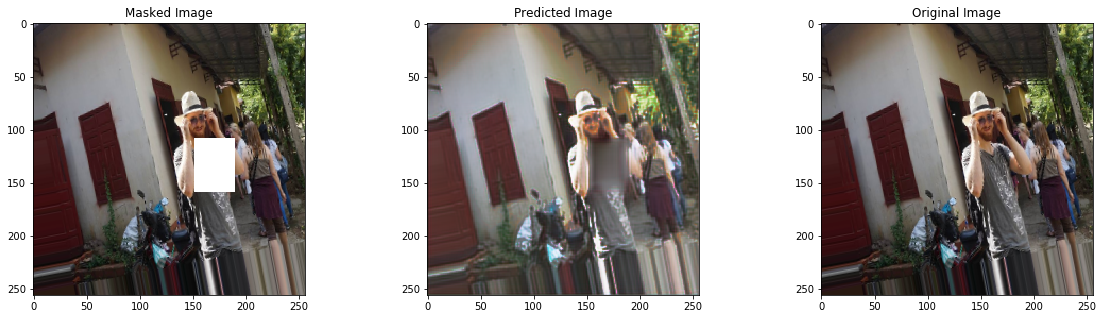

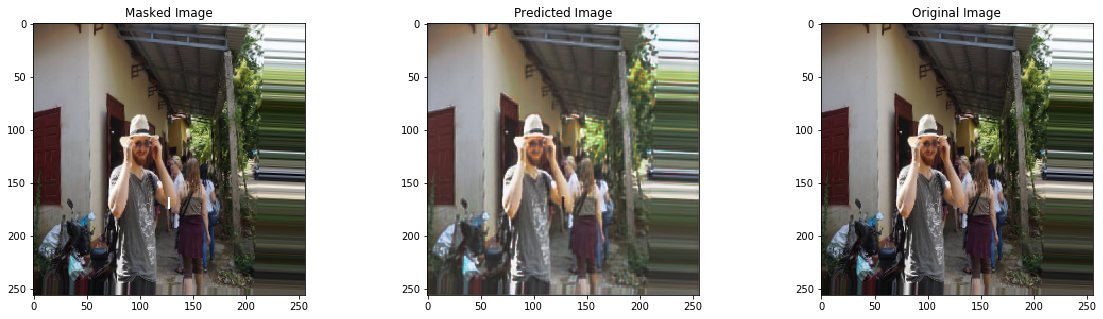

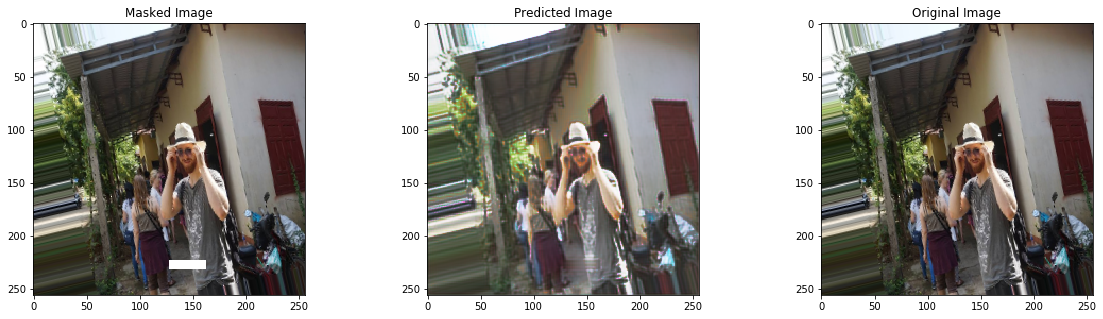

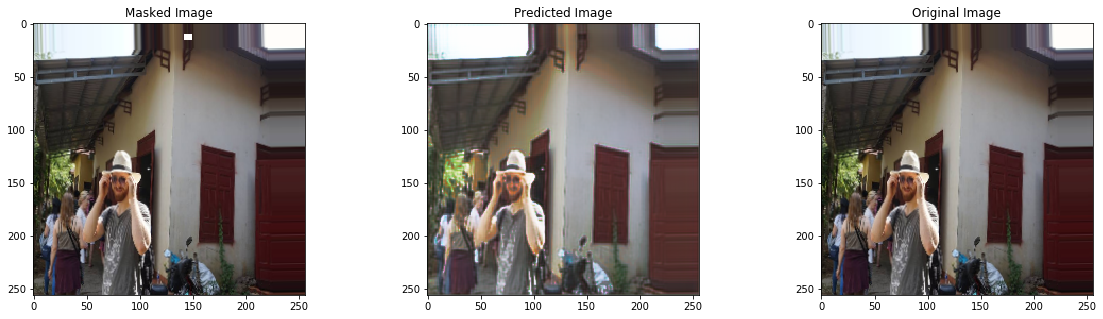

In [5]:
model = PConvUnet()
model.fit(
    generator, 
    steps_per_epoch=1000,
    epochs=1,
    plot_callback=plot_callback,
)